# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from msresist.comp_estimator import ComHyperPar, MyOwnKMEANS
from msresist.plsr import ClusterAverages, GridSearch_CV, MeasuredVsPredicted_LOOCVplot, Q2Y_across_components, R2Y_across_components
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from msresist.pre_processing import preprocessing
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
A_r = pd.read_csv('./msresist/data/Raw/20180817_JG_AM_TMT10plex_R1_psms_raw.csv', header=0)
B_r = pd.read_csv('./msresist/data/Raw/20190214_JG_AM_PC9_AXL_TMT10_AC28_R2_PSMs_raw.csv', header=0)
C_r = pd.read_csv('./msresist/data/Raw/CombinedBR3_TR1&2_raw.csv', header=0)

header = A_r.columns
treatments = A_r.columns[2:]

ABC_mc = preprocessing(A_r, B_r, C_r, motifs=True, Vfilter=True, FCfilter=True, log2T=True)

data = ABC_mc.iloc[:,2:].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

### Phenotypes

Cell Viability:

In [3]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/viability.csv')
Y_cv = Y_cv.iloc[:10, 2]

## 1. Cross-validation

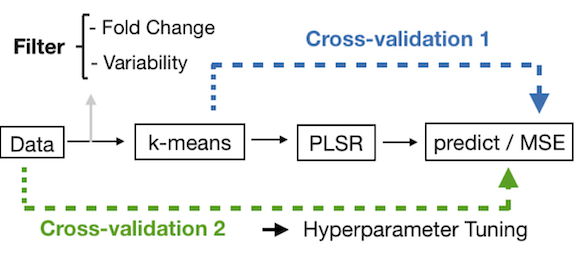

In [4]:
from IPython.display import Image
Image(filename='Model_pipeline.jpg')

### 1.1 Strategy 1: R2Y/Q2Y with Raw Data

Cross-validation fitting the entire pre-processed raw data into PLSR model:

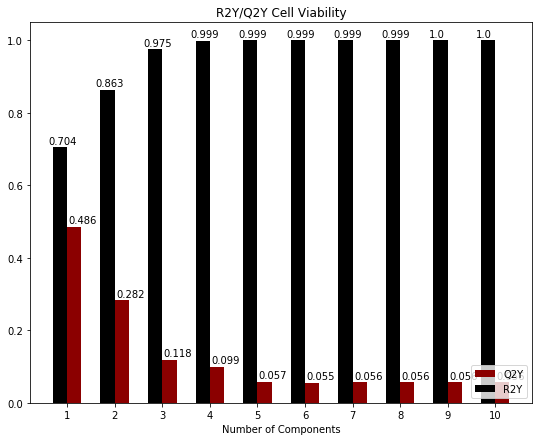

In [5]:
maxComp = 10
Q2Y = Q2Y_across_components(data, Y_cv, maxComp+1)
R2Y = R2Y_across_components(data, Y_cv, maxComp+1)

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))  

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(9,7))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkred")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y,1.03,0.01,3)
disp_values(R2Y,0.6,0.01,3)

### 1.2 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

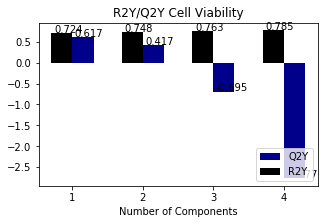

In [6]:
kmeans = MyOwnKMEANS(5, protnames, seqs).fit(data, Y=None)
centers = kmeans.transform(data)
clustermembers = kmeans.ClusterMembers(data)

maxComp = centers.shape[1]
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp)
R2Y = R2Y_across_components(centers, Y_cv, maxComp)

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp-1,maxComp-1)

fig, axs = plt.subplots(1,1,figsize=(5,3))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y,1.03,0.02,3)
disp_values(R2Y,0.74,0.01,3)

### 1.3 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

In [7]:
CVresults_max, CVresults_min, best_params = ComHyperPar(data, Y_cv, protnames, seqs)

In [8]:
print(best_params)
display(CVresults_min.iloc[:20,:])

{'kmeans__n_clusters': 3, 'plsr__n_components': 1}


,#Clusters,#Components,mean_test_scores,mean_train_scores
0,2,1,-16.572126,-8.038709
1,2,2,-11.952354,-7.275304
2,3,1,-9.513371,-6.965618
3,3,2,-11.293855,-6.297108
4,3,3,-14.802901,-6.070791
5,4,1,-10.367734,-7.491221
6,4,2,-10.789700,-6.074619
7,4,3,-19.860701,-5.191444
8,4,4,-18.883763,-4.569358
9,5,1,-10.324165,-6.985940


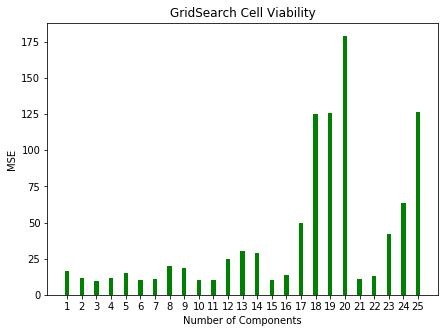

In [9]:
MSE = np.abs(CVresults_min.iloc[:25, 2])
range_ = np.linspace(1,MSE.shape[0],MSE.shape[0])

fig, axs = plt.subplots(1,1,figsize=(7,5))
plt.setp(axs, xticks=range_)
plt.bar(range_,MSE,width=0.3,align='center', color = "green")
plt.title("GridSearch Cell Viability")
plt.xlabel("Number of Components")
plt.ylabel("MSE");

## 2. Model Predicted vs Actual for best Hyperparameter Set

### 2.1 With CV Strategy 1:

In [10]:
ncomp = 2

Pearson's R:  0.7287213002418418 
 p-value:  0.016818940414346017


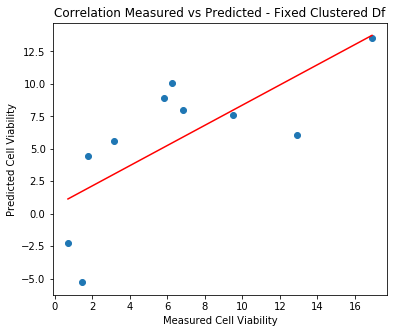

In [11]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(centers,Y_cv, PLSRegression(ncomp), fig, "none", axs)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Df")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

### 2.2 With CV Strategy 2:

In [12]:
ncl, ncomp = 5, 2
estimators = [('kmeans', MyOwnKMEANS(ncl, protnames, seqs)), ('plsr', PLSRegression(ncomp))]
pipe = Pipeline(estimators)

In [13]:
X_scores, Y_scores = pipe.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = pipe.named_steps.plsr.x_loadings_[:, 0], pipe.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = pipe.named_steps.plsr.y_loadings_[:, 0], pipe.named_steps.plsr.y_loadings_[:, 1]

Pearson's R:  0.7669802775030998 
 p-value:  0.009630511937909975


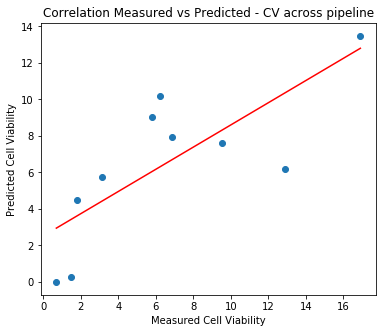

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(data,Y_cv, pipe, fig, "none", axs)
plt.title("Correlation Measured vs Predicted - CV across pipeline")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

## 3. PLSR scores and loadings 

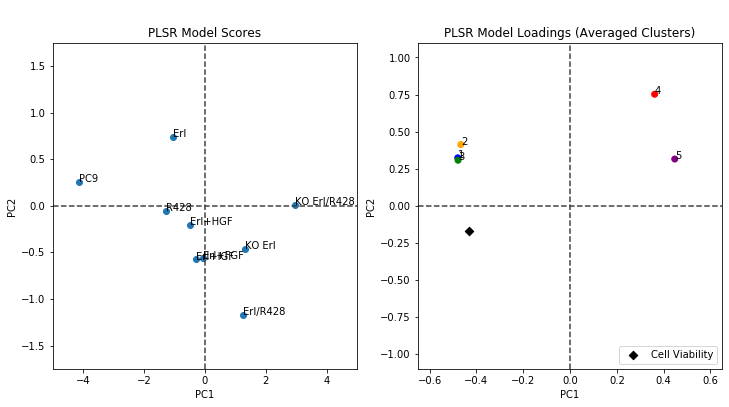

In [15]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))
colors_ = ["blue", "orange", "green", "red", "purple"]


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-5, 5])
axs[0].set_ylim([-1.75, 1.75])

for i, txt in enumerate(["1", "2", "3", "4", "5"]):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.65, 0.65])
axs[1].set_ylim([-1.1, 1.1]);

In [16]:
ClusterMembers = pipe.named_steps.kmeans.ClusterMembers(data)
count = sum(len(v) for v in ClusterMembers.values())
CM_df = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in ClusterMembers.items() ]))

#### Cluster Averages across Conditions

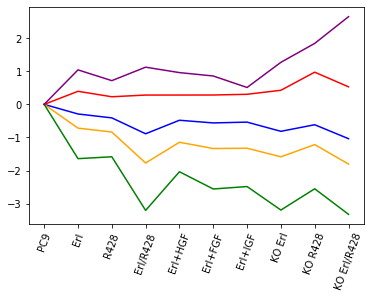

In [17]:
Centers = pipe.named_steps.kmeans.transform(data)
memb = pipe.named_steps.kmeans.ClusterMembers(data)

fig = plt.figure(figsize=(6,4))
colors_ = ["blue", "orange", "green", "red", "purple"]

centersT = np.transpose(Centers)
for i in range(centersT.shape[0]):
    plt.plot(centersT[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.xticks(np.arange(centersT.shape[1]), (treatments), rotation=70);